# Experiment 5: LLava Approach -Clip Encoder/Vicuna Decoder Frozen

This experiment tests the LLava style projections using the HuggingFace Clip encoder and the Vicuna 7b decoder. The experiment used only the pretraining stage where the mlp weights are updated with the encoder and decoder frozen.

- **Stage One**: pretrains with the encoder and decoder frozen. The only trainable parameters at this stage are in the MLP used for image projections.

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer
import datetime
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

"""
Add support for either running in collab by uploading this notebook and
mounting the directory or locally from the room or experiments folder"
"""
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # NOTE: change the drive path if running with a mounted google drive in collab
    project_root = "/content/drive/Othercomputers/My MacBook Pro/image-captioning"
else:
    cwd = os.getcwd()

    if cwd.endswith("experiments"):
        project_root = os.path.abspath(os.path.join(cwd, '..'))
    else:
        project_root = cwd

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

if IN_COLAB:
    !pip install evaluate > /dev/null 2>&1
    !pip install pycocoevalcap > /dev/null 2>&1


from vision_language_model import VisionLanguageModel
import train as train
import data_processing as dp
import download_data as get_data
import evaluation as eval


device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")

experiment = "experiment_5"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/Othercomputers/My MacBook Pro/image-captioning


In [2]:
# download data, keep it outside of the mounted directory if running in collab to avoid data transfer overhead
if IN_COLAB:
    data_dir = "/content/flickr30k_data"
else:
    data_dir = os.path.join(project_root, "flickr30k_data")

# only download data if it does not already exist
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    get_data.download_and_partition(data_dir)
else:
    print(f"Data already exists in {data_dir}, skipping download.")

# setup saving directories
model_weights_dir = os.path.join(project_root, "model_weights")
evaluations_dir = os.path.join(project_root, "evaluations")
os.makedirs(model_weights_dir, exist_ok=True)
os.makedirs(evaluations_dir, exist_ok=True)

Data already exists in /content/flickr30k_data, skipping download.


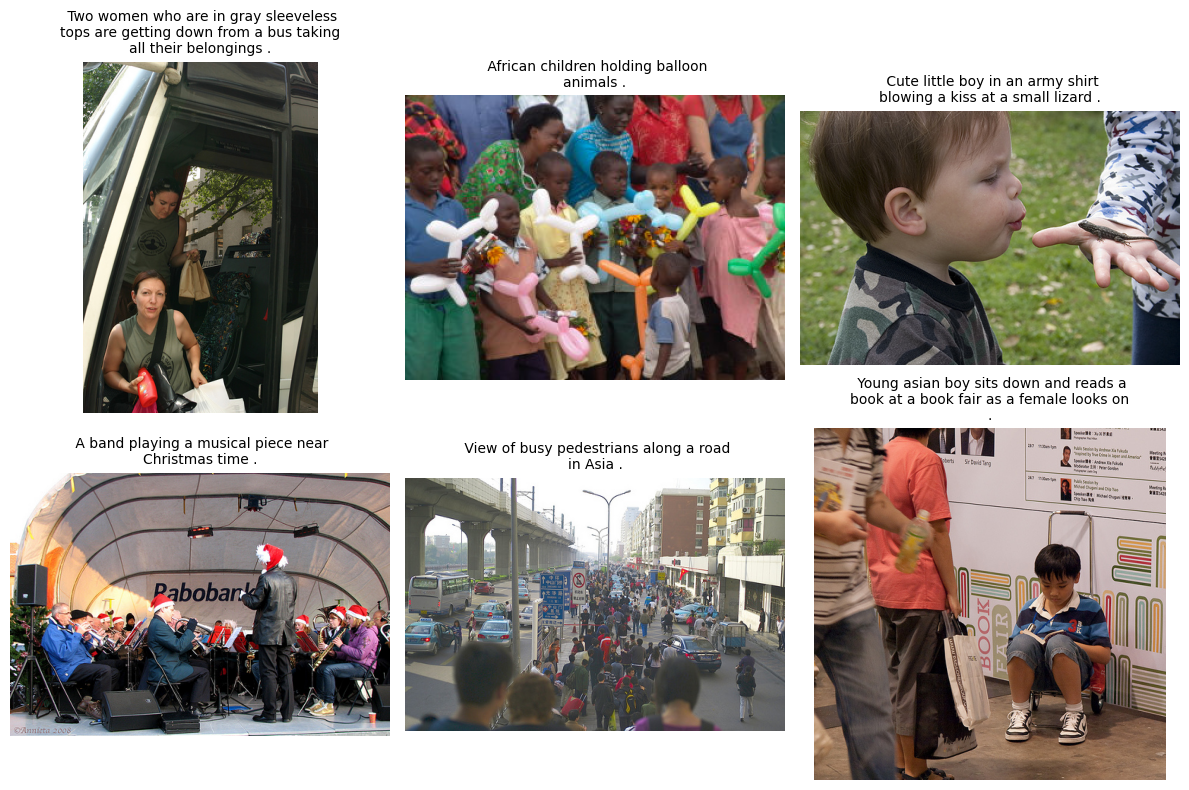

In [3]:
# load data
# Note: the train loader loads duplicate images with a 1:1 mapping of image to captions
# and the val/test loaders load images with a 1:N mapping of image to captions for evaluation
# these loaders will load batches of images rather than all images at once to avoid memory issues
train_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "train"), batch_size=4, eval_mode=False)
val_dir = os.path.join(data_dir, "val")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# visualize some training images
batch_1 = next(train_loader)
batch_2 = next(train_loader)
dp.visualize_random_captions([batch_1, batch_2])

## Stage One: Pretraining MLP

In [4]:
tokenizer = AutoTokenizer.from_pretrained("lmsys/vicuna-7b-v1.5")
tokenizer.pad_token = tokenizer.eos_token

# model config for stage one
model = VisionLanguageModel(
    image_encoder_type="clip",
    llava_projections=True,
    cross_attention=False,
    debug=False,
    decoder_type="vicuna",
    d_model=4096,
    tokenizer=tokenizer
    ).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

Initializing Vicuna model...


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuratio

In [5]:
%%time
# stage one: pretraining

max_batches=15000
num_epochs=1

train.train(
    model=model,
    train_dir=train_dir,
    val_dir=val_dir,
    loss_function=loss_fn,
    device=device,
    batch_size=2,
    num_epochs=num_epochs,
    training_type="mlp-pretrain",
    log_interval=1000,
    max_batches=max_batches,
    lr_scheduler=True,
    random_seed=1,
    learning_rate=2e-3,
    mlp_weights_path=os.path.join(model_weights_dir, f"{experiment}_pretrain_weights_{timestamp}.pt"),
    loss_plot_path=os.path.join(evaluations_dir, f"{experiment}_pretrain_loss_{timestamp}.jpg"),
    )

Encoder and decoder weights frozen for LLava-style MLP pre-training.

Epoch 1/1
Step 1000: Loss = 2.5075
Step 2000: Loss = 2.2679
Step 3000: Loss = 2.1500
Step 4000: Loss = 2.1419
Step 5000: Loss = 2.0654
Step 6000: Loss = 2.0500
Step 7000: Loss = 2.0265
Step 8000: Loss = 1.9864
Step 9000: Loss = 1.9574
Step 10000: Loss = 1.9756
Step 11000: Loss = 1.9345
Step 12000: Loss = 1.9350
Step 13000: Loss = 1.9343
Step 14000: Loss = 1.9111
Step 15000: Loss = 1.9036
MLP weights saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/model_weights/experiment_5_pretrain_weights_2025-04-15_09-48-49.pt

Training complete.
CPU times: user 2h 30min 19s, sys: 47min 19s, total: 3h 17min 39s
Wall time: 3h 16min 47s


## Evaluate on Test Set

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


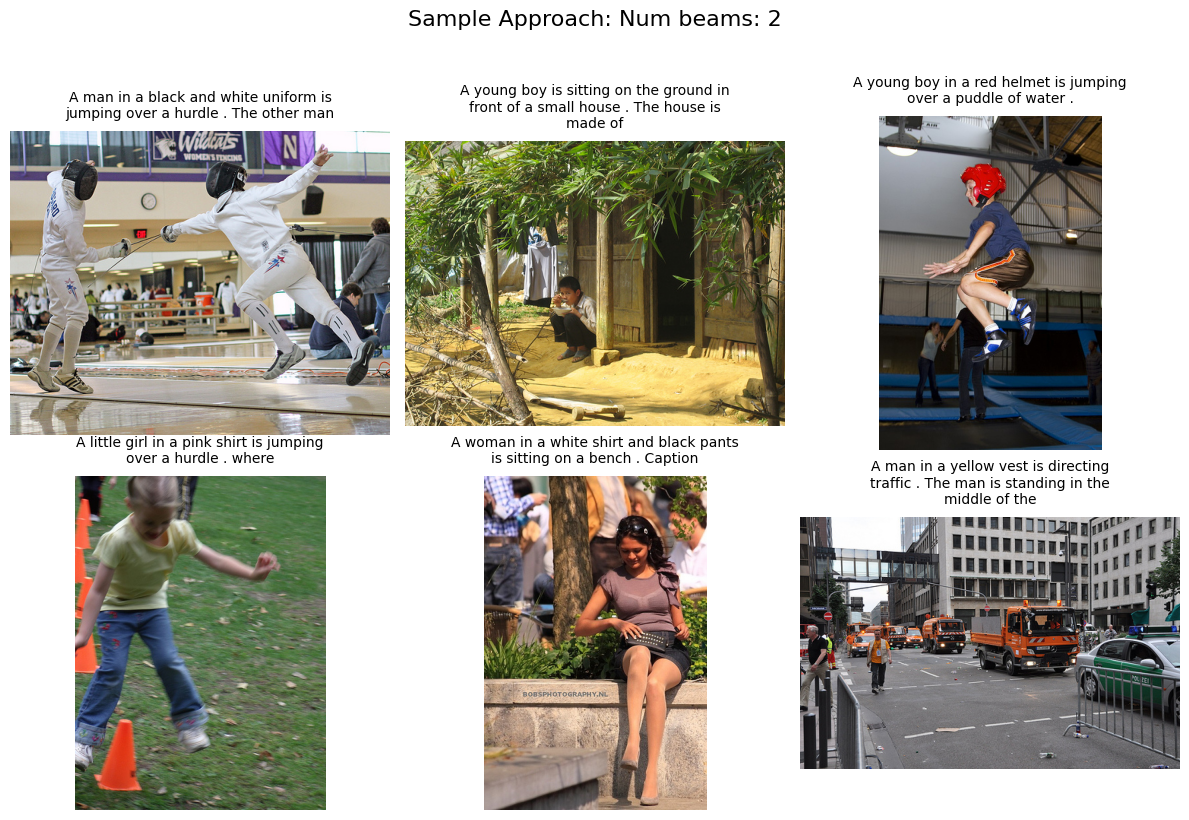

Sample Prediction: ['A man in a black and white uniform is jumping over a hurdle . The other man'], Reference: ['" two individuals wearing sparring gear , fence at a match while a Northwestern Wildcats banner hangs behind them ."', '" The competitor lunges forward seeking the point , while the defender easily steps aside"', ' Two people are playing against each other in a game of fencing .', ' Two athletes are fencing at a fencing competition .', ' Two fencers joust with one another .']
BLEU: 0.1792, CIDEr: 0.3837


In [6]:
test_loader = dp.batch_stream("captions.txt", os.path.join(data_dir, "test"), batch_size=2, eval_mode=True, seed=32)

bleu, cider = eval.evaluate_bleu_cider(
    model=model,
    data_loader=test_loader,
    display_captions=True,
    save_captions_path=os.path.join(evaluations_dir, f"{experiment}_captions_{timestamp}.jpg"),
    max_new_tokens=20,
    max_batches=500,
    num_beams=2
)

print(f"BLEU: {bleu:.4f}, CIDEr: {cider:.4f}")

In [7]:
# save experiment results
results_path = os.path.join(evaluations_dir, "results.csv")

eval.save_experiment_results(experiment, cider, bleu, results_path)

Results saved to /content/drive/Othercomputers/My MacBook Pro/image-captioning/evaluations/results.csv
